In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM, select_order
from statsmodels.tools.eval_measures import aic, bic, hqic # fpe is not directly imported

# --- 0. 设置参数 ---
data_file = 'data0913.xlsx' # 你的数据文件名
columns_to_use = ['electrovalence', 'x_coal', 'x_wind', 'x_temp', 'x_eleWest',
                  'x_demand', 'x_df', 'x_lng_1'] # 你要使用的列名

# VECM 相关参数 (可以根据需要调整)
maxlags_var_select = 5      # 为选择滞后阶数测试的最大 VAR 滞后 p
deterministic_term = 'ci'   # VECM 中的确定性项:
                            # 'nc': 无截距或趋势
                            # 'co': 仅在协整关系中有截距 (常用)
                            # 'ci': 在水平和协整关系中都有截距 (常用)
                            # 'lo': 仅在水平中有线性趋势
                            # 'li': 在水平和协整关系中都有线性趋势
lag_selection_criterion = 'aic' # 选择滞后阶数的标准 ('aic', 'bic', 'hqic', 'fpe')
irf_periods = 20            # IRF 分析的期数
fevd_periods = 20           # FEVD 分析的期数
forecast_steps = 10         # 要预测的步数

# --- 1. 数据加载与准备 ---
print(f"--- 1. 加载和准备数据 ---")
try:
    df_raw = pd.read_excel(data_file)
    # 确保索引是时间序列（如果原始数据有日期列）
    # 如果没有日期列，Pandas 会创建默认的 RangeIndex
    # df_raw['DateColumn'] = pd.to_datetime(df_raw['DateColumn'])
    # df_raw.set_index('DateColumn', inplace=True)

    df = df_raw[columns_to_use].copy()
    print(f"成功加载数据，使用列: {df.columns.tolist()}")
    print(f"数据维度: {df.shape}")

    # 检查缺失值
    if df.isnull().values.any():
        print("\n**警告**: 数据中存在缺失值。VECM 要求无缺失值。")
        print("请在运行此脚本前处理缺失值 (例如填充或删除)。")
        # 可以在这里添加处理逻辑，例如:
        # df.fillna(method='ffill', inplace=True)
        # df.dropna(inplace=True)
        # 或者直接退出
        # exit()

    # 数据标准化 (VECM 对变量尺度敏感，标准化有助于解释和数值稳定性)
    scaler = StandardScaler()
    original_index = df.index # 保存原始索引
    df_standardized = pd.DataFrame(scaler.fit_transform(df),
                                   columns=df.columns,
                                   index=original_index)
    print("\n数据已标准化 (均值为0，标准差为1)。")
    print(df_standardized.head())

except FileNotFoundError:
    print(f"错误: 数据文件 '{data_file}' 未找到。请确保文件在当前目录或提供正确路径。")
    exit()
except KeyError as e:
    print(f"错误: 列名 {e} 在 Excel 文件中未找到。请检查 'columns_to_use' 列表。")
    exit()
except Exception as e:
    print(f"加载或准备数据时发生错误: {e}")
    exit()

# --- 2. Johansen 协整检验 ---
# (确定协整秩 coint_rank)
print(f"\n--- 2. Johansen 协整检验 ---")
# 注意：这里的 k_ar_diff 是检验内部使用的 VAR 滞后，通常设为 1 或 2，
# 不一定等于最终 VECM 模型的 k_ar_diff。
# det_order 应与之后 VECM 模型中的 deterministic 参数概念上对应。
# det_order=0 (截距) 对应 deterministic='ci' 或 'co'
johansen_det_order = 0
johansen_k_ar_diff = 1 # 检验内部 VAR(p) 的 p-1

print(f"   运行检验 (确定性项={johansen_det_order}, 检验内部滞后={johansen_k_ar_diff})...")
try:
    result_johansen = coint_johansen(df_standardized.values,
                                     det_order=johansen_det_order,
                                     k_ar_diff=johansen_k_ar_diff)

    print("\n   Johansen 检验结果 (迹检验 Trace Test):")
    print("   --------------------------------------------------")
    print("    H0: rank=r | Trace Stat | 90% Crit | 95% Crit | 99% Crit ")
    print("   --------------------------------------------------")
    ranks = range(df_standardized.shape[1])
    trace_stat = result_johansen.lr1
    crit_vals_95 = result_johansen.cvt[:, 1] # 获取 95% 临界值

    coint_rank_determined = 0
    for r, stat, cv95 in zip(ranks, trace_stat, crit_vals_95):
        print(f"    r <= {r:<6} | {stat:>10.3f} | {result_johansen.cvt[r, 0]:>8.3f} | {cv95:>8.3f} | {result_johansen.cvt[r, 2]:>8.3f} ")
        if stat > cv95: # 如果统计量大于 95% 临界值
            coint_rank_determined = r + 1
        else:
            break # 第一个不能拒绝的原假设

    print("   --------------------------------------------------")
    print(f"\n   根据迹检验 (95% 水平)，确定的协整秩 (coint_rank) = {coint_rank_determined}")

    # 检查协整秩的合理性
    num_vars = df_standardized.shape[1]
    if coint_rank_determined == 0:
        print("\n   **警告**: 未发现协整关系 (秩=0)。VECM 可能不是最合适的模型。")
        print("            可以考虑在差分数据上拟合 VAR 模型。")
        # 你可以选择在这里停止或继续 (但 VECM 可能表现不佳)
        # exit()
    elif coint_rank_determined == num_vars:
        print("\n   **警告**: 协整秩等于变量数量。这表明原始序列可能是 I(0) 平稳的。")
        print("            可以考虑在水平数据上拟合 VAR 模型。")
        # 你可以选择在这里停止或继续
        # exit()

except Exception as e:
    print(f"\n   运行 Johansen 检验时出错: {e}")
    print("   无法确定协整秩，后续 VECM 无法进行。")
    exit()


# --- 3. 选择 VECM 的滞后阶数 (k_ar_diff) ---
print(f"\n--- 3. 选择 VECM 的滞后阶数 (基于 VAR(p) 的信息准则) ---")
print(f"   测试最大 VAR 滞后 p = {maxlags_var_select}, 确定性项假设 = '{deterministic_term}'")

k_ar_diff_selected = -1 # 初始化
try:
    lag_order_results = select_order(data=df_standardized,
                                     maxlags=maxlags_var_select,
                                     deterministic=deterministic_term)
    print("\n   滞后阶数选择结果 (VAR(p) perspective):")
    print(lag_order_results.summary())

    # 获取推荐的 VAR 滞后阶数 p
    optimal_p = getattr(lag_order_results, lag_selection_criterion)
    print(f"\n   根据 {lag_selection_criterion.upper()} 推荐的最优 VAR 滞后阶数 p = {optimal_p}")

    # VECM 的 k_ar_diff = p - 1
    k_ar_diff_selected = optimal_p - 1

    if k_ar_diff_selected < 0:
        print(f"\n   **警告**: 选定的 VAR 阶数 p={optimal_p} <= 0。")
        print("            这意味着 VECM(0) 只有误差修正项，没有滞后差分项。")
        print("            将设置 k_ar_diff = 0。")
        k_ar_diff_selected = 0
    else:
         print(f"   对应的 VECM 差分滞后阶数: k_ar_diff = p - 1 = {k_ar_diff_selected}")

except Exception as e:
    print(f"\n   选择滞后阶数时出错: {e}")
    print("   无法自动选择滞后阶数。")
    # 提供一个手动设置的选项或默认值
    manual_k_ar_diff = 1 # <-- 在这里设置一个合理的默认值，例如 1 或 2
    print(f"   将使用手动/默认设置的 k_ar_diff = {manual_k_ar_diff}。")
    k_ar_diff_selected = manual_k_ar_diff
    # 如果你想让脚本暂停并让用户输入，可以取消下面的注释
    # while True:
    #     try:
    #         user_input = input(f"   请输入要使用的 k_ar_diff (整数 >= 0)，或按 Enter 使用默认值 {manual_k_ar_diff}: ")
    #         if not user_input: # 用户直接按 Enter
    #             k_ar_diff_selected = manual_k_ar_diff
    #             print(f"   使用默认值: {k_ar_diff_selected}")
    #             break
    #         else:
    #             k_ar_diff_selected = int(user_input)
    #             if k_ar_diff_selected >= 0:
    #                 print(f"   使用用户输入值: {k_ar_diff_selected}")
    #                 break
    #             else:
    #                 print("   错误: k_ar_diff 必须是非负整数。")
    #     except ValueError:
    #         print("   错误: 请输入一个有效的整数。")

# 确保 k_ar_diff_selected 有一个有效的非负值
if k_ar_diff_selected < 0:
     print("\n错误：未能确定有效的 k_ar_diff。无法继续。")
     exit()

# --- 4. 定义并拟合 VECM 模型 ---
print(f"\n--- 4. 定义并拟合 VECM 模型 ---")
print(f"   使用数据: df_standardized (水平数据)")
print(f"   差分滞后阶数 (k_ar_diff): {k_ar_diff_selected}")
print(f"   协整秩 (coint_rank): {coint_rank_determined}")
print(f"   确定性项 (deterministic): '{deterministic_term}'")

vecm_results = None # 初始化结果变量
model_is_stable = False # 初始化稳定性标志

# 创建 VECM 模型实例
vecm_model = VECM(endog=df_standardized,
                    k_ar_diff=k_ar_diff_selected,
                    coint_rank=coint_rank_determined,
                    deterministic=deterministic_term)

# 拟合模型
vecm_results = vecm_model.fit()

# --- 5. 查看模型结果和诊断 ---
print("\n--- 5. VECM 模型拟合结果与诊断 ---")
print("\n   a) 模型摘要:")
# 使用 repr() 获取更详细的摘要信息，避免截断
print(repr(vecm_results.summary()))


--- 1. 加载和准备数据 ---
成功加载数据，使用列: ['electrovalence', 'x_coal', 'x_wind', 'x_temp', 'x_eleWest', 'x_demand', 'x_df', 'x_lng_1']
数据维度: (912, 8)

数据已标准化 (均值为0，标准差为1)。
   electrovalence    x_coal    x_wind    x_temp  x_eleWest  x_demand  \
0       -1.748710 -1.321129 -0.352626 -1.132686  -1.370895 -1.731357   
1       -0.052336 -1.321129 -0.071652 -1.013699  -1.229392 -1.156782   
2        0.448001 -1.321129 -0.147696 -0.930551  -1.106328 -0.875890   
3        0.640195 -1.145088  0.320164 -0.788626  -1.017202 -0.532865   
4        0.533419 -1.052319 -0.736710 -0.514811  -0.937563 -0.515390   

       x_df   x_lng_1  
0 -1.412505  0.747941  
1 -1.354792  0.747941  
2 -1.520175  0.747941  
3 -1.392693  0.161453  
4 -1.592214  0.644997  

--- 2. Johansen 协整检验 ---
   运行检验 (确定性项=0, 检验内部滞后=1)...

   Johansen 检验结果 (迹检验 Trace Test):
   --------------------------------------------------
    H0: rank=r | Trace Stat | 90% Crit | 95% Crit | 99% Crit 
   --------------------------------------------------



--- 5b: 通过伴随矩阵手动检查 VECM 稳定性 ---
   已获取系数: 变量数 k=8, 等价VAR阶数 p=3 (VECM k_ar_diff=2), 协整秩 r=6
   alpha 形状: (8, 6), beta 形状: (8, 6)
   k_ar_diff_selected: 2
   gamma_matrices 形状 (在访问之前): (8, 16)
   gamma 形状 (修改后假设为 2D): (8, 16)
   已计算 3 个水平 VAR 系数矩阵 (A_1 到 A_p)。
   已构建伴随矩阵 F，形状: (24, 24)
   已计算 24 个特征值。
   特征值模长 (降序): 
[1.       1.       0.963881 0.928128 0.928128 0.841989 0.735455 0.735455
 0.51705  0.51705  0.421119 0.421119 0.403461 0.403461 0.36453  0.326406
 0.326406 0.293258 0.293258 0.292915 0.292915 0.178514 0.178514 0.095283]

   稳定性检查:
     - 预期单位根数量 (k-r): 2
     - 找到模长 >= 1.0000 的根数量: 2
     - 找到模长 < 1.0000 的根数量: 22
     - 找到的总根数: 24 (应等于 kp=24)

   结论: 稳定性条件满足。
         单位根数量与预期一致，且其余所有根的模长严格小于 1。

--- 6. 后验分析 (IRF, FEVD, 预测) ---

   a) 计算和绘制脉冲响应函数 (IRF):
      计算 IRF，持续 20 期...
      绘制 IRF 图形 (冲击源: 第一个变量)...
      计算或绘制 IRF 时出错: name 'impulse_var' is not defined

   b) 计算和绘制预测误差方差分解 (FEVD):
      计算 FEVD，持续 20 期 (手动计算)...
      FEVD 结果 (手动计算):
Response Variable electrovalen

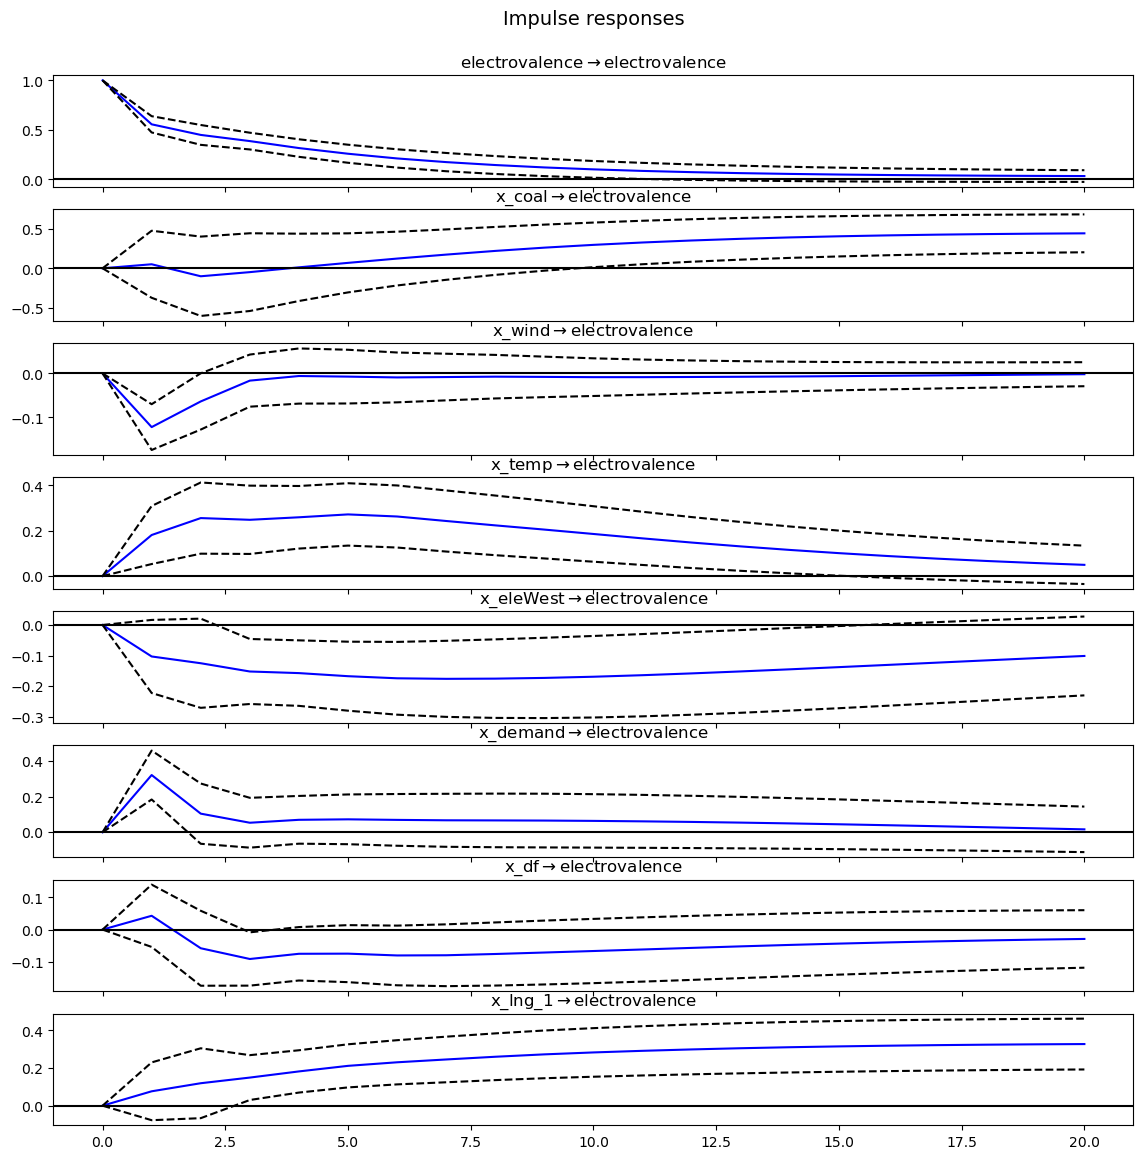

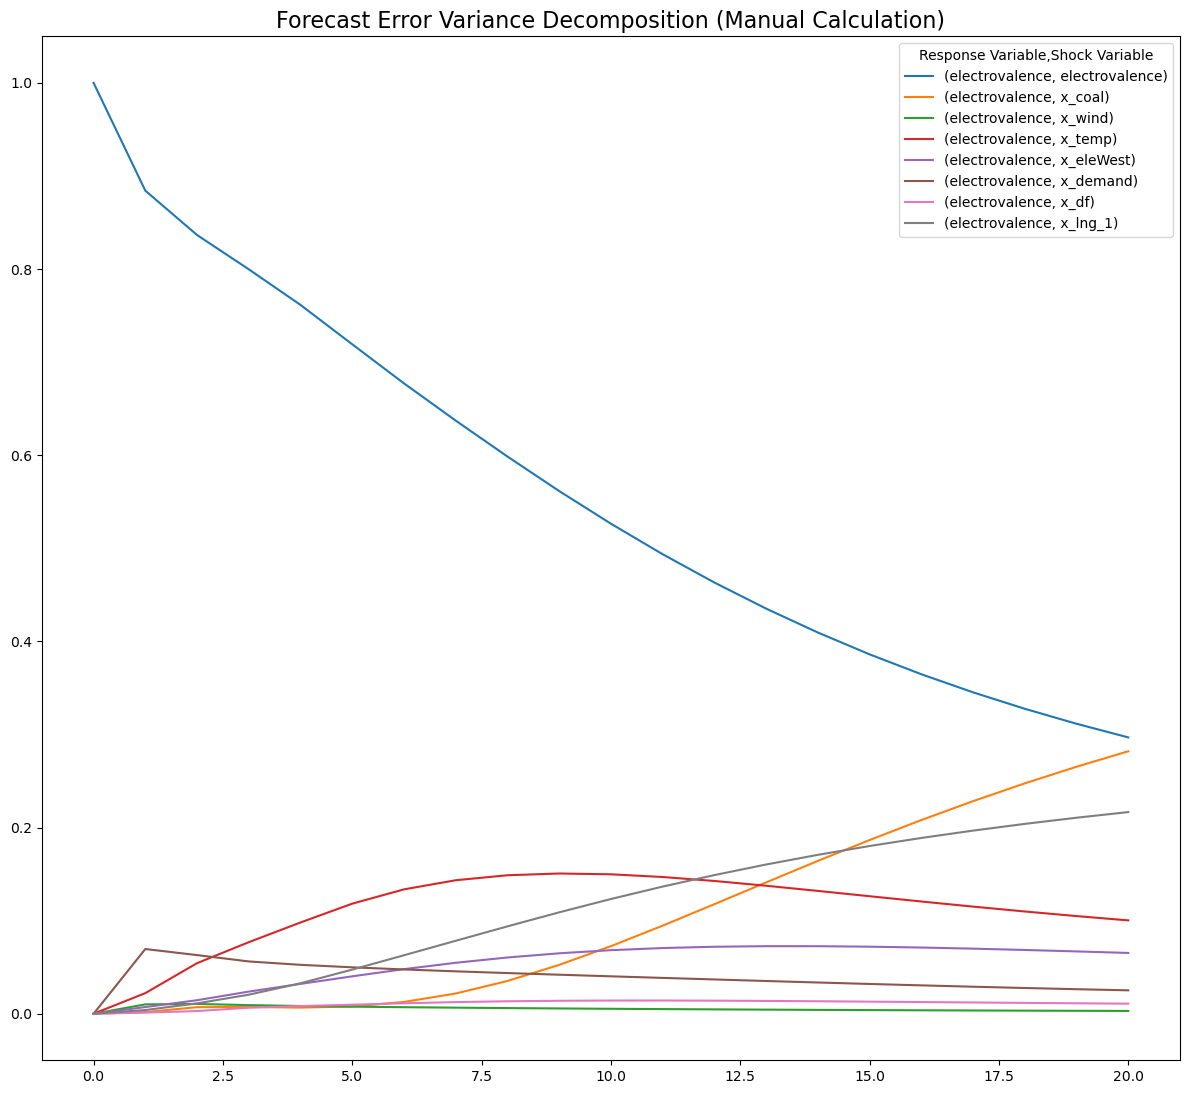


   c) 使用 VECM 模型进行预测:
      预测未来 10 步...
      警告: 无法推断日期频率或索引非日期类型。使用从 0 开始的整数索引进行预测。

      预测值 (未来 10 步):
     electrovalence  x_coal  x_wind  x_temp  x_eleWest  x_demand    x_df  \
912         -1.0129 -1.0425 -0.3802  1.0627    -1.9361    1.3484  2.0011   
913         -0.6749 -1.0829 -0.4832  0.9754    -1.8416    1.4440  1.8201   
914         -0.4865 -1.1267 -0.5105  0.8903    -1.7585    1.4745  1.6454   
915         -0.3608 -1.1686 -0.5077  0.8179    -1.6886    1.4687  1.5127   
916         -0.2626 -1.2080 -0.5103  0.7575    -1.6268    1.4509  1.3950   
917         -0.1909 -1.2451 -0.5111  0.7032    -1.5723    1.4250  1.2830   
918         -0.1428 -1.2800 -0.5060  0.6499    -1.5235    1.3919  1.1805   
919         -0.1126 -1.3126 -0.4983  0.5973    -1.4794    1.3536  1.0873   
920         -0.0961 -1.3429 -0.4899  0.5461    -1.4394    1.3116  1.0018   
921         -0.0905 -1.3711 -0.4805  0.4966    -1.4031    1.2673  0.9234   

     x_lng_1  
912  -0.7286  
913  -0.7621  
914  -0.

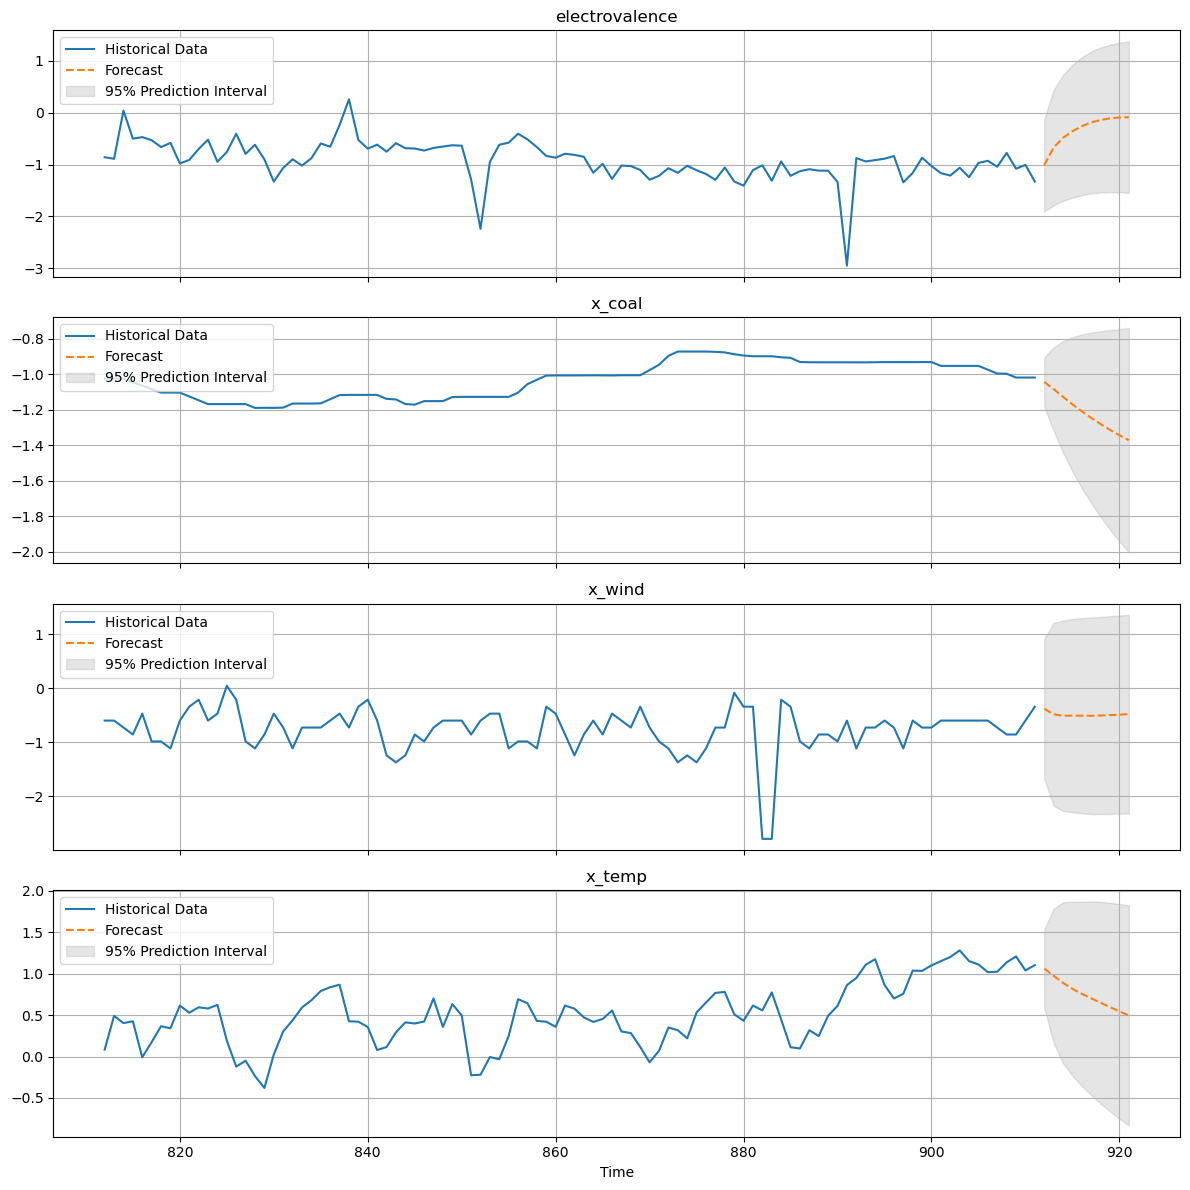


--- VECM 分析脚本执行完毕 ---


In [2]:
print("\n--- 5b: 通过伴随矩阵手动检查 VECM 稳定性 ---")

model_is_stable = False # 初始化稳定性标志

if vecm_results is not None:
    try:
        # --- 步骤 1: 获取 VECM 估计系数 ---
        k = df_standardized.shape[1]  # 变量数量
        p = k_ar_diff_selected + 1    # 等价 VAR 模型的滞后阶数
        r = coint_rank_determined     # 协整秩

        # 从结果中获取系数
        # 注意：务必确认这些属性名称在你的 statsmodels 版本中是正确的
        alpha = vecm_results.alpha    # 载荷系数 (k x r)
        beta = vecm_results.beta      # 协整向量 (k x r) - 注意标准化方式可能不同
        # Gamma 矩阵 (短期动态系数)
        # vecm_results.gamma 通常是 (k_ar_diff, k, k) 数组，即 [Γ_1, ..., Γ_{p-1}]

        print(f"   已获取系数: 变量数 k={k}, 等价VAR阶数 p={p} (VECM k_ar_diff={k_ar_diff_selected}), 协整秩 r={r}")
        print(f"   alpha 形状: {alpha.shape}, beta 形状: {beta.shape}")

        # 调试：打印 gamma_matrices 的形状
        print(f"   k_ar_diff_selected: {k_ar_diff_selected}") # 确保 k_ar_diff_selected 的值正确
        print(f"   gamma_matrices 形状 (在访问之前): {vecm_results.gamma.shape}") # 关键的调试信息

        gamma_matrices = vecm_results.gamma # 形状 (k, k * k_ar_diff)
        print(f"   gamma 形状 (修改后假设为 2D): {gamma_matrices.shape}")

        # --- 步骤 2: 计算等价 VAR(p) 模型的系数矩阵 (A_1 到 A_p) ---
        Pi = alpha @ beta.T  # 计算 Π = αβ' (k x k 矩阵)
        A_matrices = [] # 用于存储 A_1 到 A_p
        identity_k = np.identity(k) # k 阶单位阵

        # 计算 A_1
        if p == 1: # 特殊情况: VECM(0) -> VAR(1)
             A_1 = identity_k + Pi
             A_matrices.append(A_1)
        else: # p > 1
            # 从 2D gamma_matrices 中提取 Γ_1
            Gamma_1 = gamma_matrices[:, 0:k] #  取列 0 到 k-1
            A_1 = identity_k + Pi + Gamma_1
            A_matrices.append(A_1)

            # 计算 A_i = Γ_i - Γ_{i-1} for i = 2 to p-1
            for i in range(1, k_ar_diff_selected): # i 对应 Γ 的下标 (从 Γ_2 开始)
                # 从 2D gamma_matrices 中提取 Γ_i 和 Γ_{i-1}
                Gamma_i = gamma_matrices[:, i*k : (i+1)*k]      # 列索引从 i*k 到 (i+1)*k - 1
                Gamma_i_minus_1 = gamma_matrices[:, (i-1)*k : i*k] # 列索引从 (i-1)*k 到 i*k - 1
                A_i_calc = Gamma_i - Gamma_i_minus_1
                A_matrices.append(A_i_calc) # 存入的是 A_2, A_3, ..., A_{p-1}

            # 计算 A_p = -Γ_{p-1}
            Gamma_p_minus_1 = gamma_matrices[:, (k_ar_diff_selected-1)*k : k_ar_diff_selected*k] # 取最后一组 Γ，列索引从 (p-2)*k 到 (p-1)*k - 1
            A_p = -Gamma_p_minus_1
            A_matrices.append(A_p)


        print(f"   已计算 {len(A_matrices)} 个水平 VAR 系数矩阵 (A_1 到 A_p)。")
        # 检查计算得到的 A 矩阵数量是否等于 p
        if len(A_matrices) != p:
             print(f"   **错误**: 计算得到的 A 矩阵数量 ({len(A_matrices)}) 与预期的 p ({p}) 不符!")
             raise ValueError("计算 VAR 系数时出错")


        # --- 步骤 3: 构建 VAR(p) 的伴随矩阵 (Companion Matrix F) ---
        # F 是一个 kp x kp 的矩阵
        kp = k * p
        companion_matrix = np.zeros((kp, kp))

        # 填充第一行块: [A_1, A_2, ..., A_p]
        for i in range(p):
            companion_matrix[0:k, i*k:(i+1)*k] = A_matrices[i]

        # 填充下面的单位矩阵块
        if p > 1:
            # 在 (k, 0), (2k, k), ..., ((p-1)k, (p-2)k) 的位置填充 I_k
            for i in range(1, p):
                companion_matrix[i*k:(i+1)*k, (i-1)*k:i*k] = identity_k

        print(f"   已构建伴随矩阵 F，形状: {companion_matrix.shape}")

        # --- 步骤 4: 计算伴随矩阵的特征值 ---
        eigenvalues = np.linalg.eigvals(companion_matrix)
        print(f"   已计算 {len(eigenvalues)} 个特征值。")

        # --- 步骤 5: 检查特征值的模长以判断稳定性 ---
        moduli = np.abs(eigenvalues)
        moduli_sorted = np.sort(moduli)[::-1] # 按降序排序

        print(f"   特征值模长 (降序): \n{np.round(moduli_sorted, 6)}") # 显示更多小数位

        # 稳定性检查参数
        expected_unit_roots = k - r # 预期的单位根数量
        tolerance = 1e-8 # 判断模长是否接近 1 的容忍度

        # 计算模长接近 1 的根的数量 (>= 1-tolerance)
        num_unit_roots_found = np.sum(moduli >= (1.0 - tolerance))
        # 计算模长严格小于 1 的根的数量 (< 1-tolerance)
        num_stable_roots_found = np.sum(moduli < (1.0 - tolerance))

        print(f"\n   稳定性检查:")
        print(f"     - 预期单位根数量 (k-r): {expected_unit_roots}")
        print(f"     - 找到模长 >= {1.0 - tolerance:.4f} 的根数量: {num_unit_roots_found}")
        print(f"     - 找到模长 < {1.0 - tolerance:.4f} 的根数量: {num_stable_roots_found}")
        print(f"     - 找到的总根数: {num_unit_roots_found + num_stable_roots_found} (应等于 kp={kp})")

        # 最终稳定性判断
        # 条件：单位根数量正好是 k-r，并且其余所有根的模长严格小于 1
        # 注意：要同时满足两个条件
        if abs(num_unit_roots_found - expected_unit_roots) <= 0 and \
           (num_stable_roots_found == kp - expected_unit_roots):
             # 严格判断：确保模长 >= 1-tol 的根数量正好是 k-r，
             # 并且模长 < 1-tol 的根数量正好是 kp - (k-r)
             # 这也隐含了没有根的模长显著大于 1
             print("\n   结论: 稳定性条件满足。")
             print("         单位根数量与预期一致，且其余所有根的模长严格小于 1。")
             model_is_stable = True # 设置稳定性标志为 True
        else:
             print("\n   结论: 稳定性条件不满足。")
             if num_unit_roots_found > expected_unit_roots:
                 print(f"         原因: 发现 {num_unit_roots_found} 个根的模长接近或超过 1，超过了预期的 {expected_unit_roots} 个单位根。可能存在额外的单位根或爆炸性根。")
             elif num_unit_roots_found < expected_unit_roots:
                 print(f"         原因: 发现 {num_unit_roots_found} 个根的模长接近 1，少于预期的 {expected_unit_roots} 个单位根。这可能表示数值计算问题或模型设定问题。")
             elif num_stable_roots_found != kp - expected_unit_roots:
                 # 单位根数量对了，但稳定根数量不对，意味着有根的模长 > 1
                 num_explosive = kp - num_unit_roots_found - num_stable_roots_found
                 print(f"         原因: 单位根数量 ({num_unit_roots_found}) 符合预期，但稳定根数量 ({num_stable_roots_found}) 不符合预期 ({kp - expected_unit_roots})。")
                 print(f"               这表明存在 {num_explosive} 个模长大于 1 的爆炸性根。")
             else: # 其他未预料情况
                 print("         原因: 未知稳定性问题，请检查特征值模长列表。")
             model_is_stable = False # 设置稳定性标志为 False

    except AttributeError as ae:
        print(f"\n   错误: 访问 VECM 结果属性时出错: {ae}")
        print("   无法从 vecm_results 对象中获取必要的系数 (alpha, beta, gamma)。")
        print("   手动稳定性检查失败。")
        model_is_stable = False
    except np.linalg.LinAlgError as lae:
        print(f"\n   错误: 计算特征值时发生线性代数错误: {lae}")
        print("   无法计算伴随矩阵的特征值。手动稳定性检查失败。")
        model_is_stable = False
    except Exception as e:
        print(f"\n   错误: 手动稳定性检查过程中发生意外错误: {e}")
        model_is_stable = False

else:
    print("\n   跳过手动稳定性检查，因为 VECM 结果对象 (vecm_results) 不可用。")
    model_is_stable = False # 确保标志为 False


# --- 6. 后验分析 (仅当模型稳定时进行) ---
def manual_fevd(vecm_results, periods=10):
    """
    手动计算 VECM 模型的预测误差方差分解 (FEVD)。

    参数:
    vecm_results: statsmodels VECMResults 对象
    periods: 预测期数 (FEVD 的时间范围)

    返回:
    pandas.DataFrame: FEVD 结果，行索引为预测期数，列索引为变量，
                     每个单元格的值代表该变量的预测误差方差被各个冲击解释的比例。
    """
    irf_analysis = vecm_results.irf(periods=periods) # 获取 IRAnalysis 对象
    irf_values = irf_analysis.irfs # 从 IRAnalysis 对象中获取 irfs 属性，它才是 NumPy 数组 (维度: periods+1, 变量数, 变量数)
    num_variables = vecm_results.neqs
    fevd_result = np.zeros((periods + 1, num_variables, num_variables)) # 初始化 FEVD 结果数组

    # 初始化累积平方 IRF
    cumulative_irf_squared = np.zeros((num_variables, num_variables))

    for horizon in range(periods + 1):
        for i in range(num_variables): # 被解释变量 (响应变量)
            for j in range(num_variables): # 冲击变量
                cumulative_irf_squared[i, j] += irf_values[horizon, i, j]**2 # 累积平方 IRF

        # 归一化
        for i in range(num_variables): # 被解释变量
            total_variance = np.sum(cumulative_irf_squared[i, :]) # 计算当前期所有冲击对变量 i 的总方差贡献
            if total_variance > 0: # 避免除以零
                for j in range(num_variables): # 冲击变量
                    fevd_result[horizon, i, j] = cumulative_irf_squared[i, j] / total_variance
            else:
                fevd_result[horizon, i, :] = 0 # 如果总方差为零，FEVD 设为 0

    # 创建 DataFrame 用于展示结果
    fevd_df = pd.DataFrame(fevd_result.reshape((periods + 1, num_variables * num_variables)),
                           index=range(periods + 1),
                           columns=pd.MultiIndex.from_product([vecm_results.names, vecm_results.names],
                                                               names=['Response Variable', 'Shock Variable']))
    return fevd_df

if model_is_stable and vecm_results is not None:
    print("\n--- 6. 后验分析 (IRF, FEVD, 预测) ---")

    # a) 脉冲响应函数 (IRF)
    print("\n   a) 计算和绘制脉冲响应函数 (IRF):")
    print(f"      计算 IRF，持续 {irf_periods} 期...")
    try:
        irf = vecm_results.irf(periods=irf_periods)
        print("      绘制 IRF 图形 (冲击源: 第一个变量)...")
        # 选择一个冲击源进行绘制，例如第一个变量
        response_var = df_standardized.columns[0]
        fig_irf = irf.plot(impulse=None,
                           response=response_var, # 显示对所有变量的响应
                           orth=False,    # VECM 通常不直接正交化
                           signif=0.05,   # 95% 置信区间
                           plot_stderr=True,
                           figsize=(12, max(8, 1.5 * num_vars))) # 调整图形大小
        fig_irf.suptitle(f'Impulse Responses to a shock in {impulse_var}', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 调整布局防止标题重叠
        plt.show()

        # 你可以取消注释下面的代码来绘制其他冲击源的响应
        # impulse_var_2 = df_standardized.columns[1]
        # fig_irf_2 = irf.plot(impulse=impulse_var_2, orth=False, signif=0.05, plot_stderr=True, figsize=(12, max(8, 1.5 * num_vars)))
        # fig_irf_2.suptitle(f'Impulse Responses to a shock in {impulse_var_2}', fontsize=16)
        # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # plt.show()

    except Exception as e:
        print(f"      计算或绘制 IRF 时出错: {e}")
        
    # b) 预测误差方差分解 (FEVD)
    print("\n   b) 计算和绘制预测误差方差分解 (FEVD):")
    print(f"      计算 FEVD，持续 {fevd_periods} 期 (手动计算)...")
    try:
        fevd_manual_df = manual_fevd(vecm_results, periods=fevd_periods)
        print("      FEVD 结果 (手动计算):")
        print(fevd_manual_df)  # 打印 FEVD DataFrame

        print("      绘制 FEVD 图形...")
        # 为了绘图更清晰，我们这里只绘制每个变量的方差分解，即每个响应变量被所有冲击解释的比例
        # 我们选取 fevd_manual_df 的前 num_vars 列进行绘制，这些列代表每个响应变量的方差分解
        fig_fevd = fevd_manual_df.iloc[:, :num_vars].plot(figsize=(12, max(10, 1.5 * num_vars)))
        fig_fevd.set_title('Forecast Error Variance Decomposition (Manual Calculation)', fontsize=16) # 使用 set_title
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    except Exception as e:
        print(f"      计算或绘制 FEVD 时出错: {e}")
        
    # c) 预测 (Forecasting)
    print("\n   c) 使用 VECM 模型进行预测:")
    print(f"      预测未来 {forecast_steps} 步...")
    try:
        # 获取预测结果，包括预测值和置信区间
        # predict 返回 (预测值, 预测下界, 预测上界)
        forecast_values, lower_ci, upper_ci = vecm_results.predict(steps=forecast_steps, alpha=0.05) # alpha=0.05 for 95% CI

        # 创建预测结果的 DataFrame
        last_date = df_standardized.index[-1]
        forecast_index = None
        # 尝试创建未来日期索引
        try:
            # 尝试推断频率
            freq = pd.infer_freq(df_standardized.index)
            if freq:
                forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq=freq)[1:]
                print(f"      使用推断的频率 '{freq}' 创建预测日期索引。")
            else:
                 raise ValueError("无法推断频率") # 如果推断失败，进入 except
        except (TypeError, ValueError): # 处理非日期索引或无法推断频率的情况
            print("      警告: 无法推断日期频率或索引非日期类型。使用从 0 开始的整数索引进行预测。")
            start_index = len(df_standardized)
            forecast_index = pd.RangeIndex(start=start_index, stop=start_index + forecast_steps, step=1)

        # 创建包含预测值和置信区间的 DataFrame
        df_forecast = pd.DataFrame(forecast_values, index=forecast_index, columns=df_standardized.columns)
        df_lower_ci = pd.DataFrame(lower_ci, index=forecast_index, columns=[f'{col}_lower' for col in df_standardized.columns])
        df_upper_ci = pd.DataFrame(upper_ci, index=forecast_index, columns=[f'{col}_upper' for col in df_standardized.columns])
        df_forecast_all = pd.concat([df_forecast, df_lower_ci, df_upper_ci], axis=1)


        print(f"\n      预测值 (未来 {forecast_steps} 步):")
        print(df_forecast.round(4))
        # print("\n      预测区间 (95%):")
        # print(df_forecast_all[[f'{col}_lower' for col in df_standardized.columns] + [f'{col}_upper' for col in df_standardized.columns]].round(4))


        # 可视化预测结果 (例如只绘制前几个变量)
        num_vars_to_plot = min(4, df_standardized.shape[1]) # 最多绘制 4 个
        print(f"\n      绘制前 {num_vars_to_plot} 个变量的历史数据和预测值...")

        # 确定历史数据的绘制范围，避免图形过于拥挤
        history_periods_to_plot = min(len(df_standardized), 100) # 最多显示最近 100 个历史点
        plot_data_history = df_standardized.iloc[-history_periods_to_plot:]

        fig_forecast, axes = plt.subplots(num_vars_to_plot, 1, figsize=(12, 3 * num_vars_to_plot), sharex=True)
        if num_vars_to_plot == 1: # 如果只有一个变量，axes 不是数组
            axes = [axes]

        for i, col in enumerate(df_standardized.columns[:num_vars_to_plot]):
            ax = axes[i]
            # 绘制历史数据
            plot_data_history[col].plot(ax=ax, label='Historical Data')
            # 绘制预测值
            df_forecast[col].plot(ax=ax, label='Forecast', linestyle='--')
            # 绘制置信区间
            ax.fill_between(df_forecast_all.index,
                            df_forecast_all[f'{col}_lower'],
                            df_forecast_all[f'{col}_upper'],
                            color='gray', alpha=0.2, label='95% Prediction Interval')

            ax.set_title(col)
            ax.legend(loc='upper left')
            ax.grid(True)

        plt.xlabel("Time")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"      进行预测或绘图时出错: {e}")

elif vecm_results is None:
    print("\n--- 跳过后验分析 ---")
    print("   由于 VECM 模型未能成功拟合，无法进行 IRF、FEVD 或预测。")
else: # 模型拟合成功但稳定性检查失败
    print("\n--- 跳过后验分析 ---")
    print("   由于 VECM 模型不稳定，不进行 IRF、FEVD 或预测分析。")


print("\n--- VECM 分析脚本执行完毕 ---")

In [ ]:
# 1. 导入 rpy2 相关模块
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter

# 2. 激活 pandas DataFrame 到 R data.frame 的自动转换
pandas2ri.activate()

# 准备你的 Python 数据 (假设 df_standardized 是你的 pandas DataFrame)
# df_standardized = ... # 你的数据加载和预处理代码
endog_vars = ['electrovalence', 'x_coal', 'x_wind', 'x_temp', 'x_eleWest', 'x_demand', 'x_df', 'x_lng_1']
data_for_r = df_standardized[endog_vars].copy() # 选择需要的列

# 3. 定义 R 代码将在其中执行的环境
r = robjects.r

# 4. 导入 R 包
try:
    tsDyn = importr('tsDyn')
    vars_r = importr('vars') # vars 包可能需要用于 VECM 估计或数据准备
    base = importr('base') # R 的基础包
    stats = importr('stats') # R 的统计包
    print("R packages 'tsDyn' and 'vars' loaded successfully via rpy2.")
except Exception as e:
    print(f"Error importing R packages via rpy2: {e}")
    print("Please ensure R is installed and the packages 'tsDyn', 'vars' are installed in R.")
    # 退出或采取其他错误处理措施

# 5. 将 Python DataFrame 转换为 R data.frame
try:
    r_df = pandas2ri.py2rpy(data_for_r)
    # 将 R data.frame 转换为 R 的时间序列对象 (ts)
    # 假设你的数据是月度的 (frequency=12)，根据你的实际情况修改 frequency
    # 你可能还需要指定 start 参数，例如 start=c(year, month)
    r_ts = r.ts(r_df, frequency=12) # 或者 frequency=4 (季度), 1 (年度) 等
    print("Data successfully converted to R time series object.")
except Exception as e:
    print(f"Error converting data to R time series object: {e}")
    # 退出或采取其他错误处理措施

# 6. 定义 SVECM 的参数
k = len(endog_vars) # 变量数量
p = 2             # VECM 的滞后阶数 (k_ar_diff)
r_coint = 6       # 协整秩 (coint_rank)

# 7. 定义结构识别矩阵 (A 或 B 矩阵) - 这是关键！
# --- Define Adjusted A Matrix ---
# Change: A[7, 2] = NA (Wind shock affects Local Gen)
# Added Restriction: A[7, 8] = 0 (Price shock doesn't affect Local Gen contemporaneously)

# Col 1: Structural Shock to Temp (ε_temp)
c1 <- c( NA, NA, NA, NA, NA, NA, NA, NA ) # 0 zeros

# Col 2: Structural Shock to Wind (ε_wind)
#        - Does NOT affect Temp (row 1).
#        - *NOW* affects Local Gen (row 7 = NA).
c2 <- c(  0, NA, NA, NA, NA, NA, NA, NA ) # 1 zero (A[7,2] is now NA)

# Col 3: Structural Shock to Coal (ε_coal)
#        - Does NOT affect Temp (row 1), Wind (row 2).
#        - Does NOT affect LNG price contemporaneously (row 4).
c3 <- c(  0,  0, NA,  0, NA, NA, NA, NA ) # 3 zeros

# Col 4: Structural Shock to LNG (ε_lng_1)
#        - Does NOT affect Temp (row 1), Wind (row 2), Coal (row 3).
c4 <- c(  0,  0,  0, NA, NA, NA, NA, NA ) # 3 zeros

# Col 5: Structural Shock to Demand (ε_demand)
#        - Does NOT affect Temp, Wind, Coal, LNG (rows 1-4).
c5 <- c(  0,  0,  0,  0, NA, NA, NA, NA ) # 4 zeros

# Col 6: Structural Shock to West Power (ε_eleWest)
#        - Does NOT affect Temp, Wind, Coal, LNG, Demand (rows 1-5).
#        - Does NOT affect Local Generation contemporaneously (row 7).
c6 <- c(  0,  0,  0,  0,  0, NA,  0, NA ) # 6 zeros

# Col 7: Structural Shock to Local Generation (ε_df)
#        - Does NOT affect Temp, Wind, Coal, LNG, Demand, WestPower (rows 1-6).
#        - Affects LocalGen (row 7), Price (row 8).
c7 <- c(  0,  0,  0,  0,  0,  0, NA, NA ) # 6 zeros

# Col 8: Structural Shock to Price (ε_price)
#        - Does NOT affect Temp, Wind, Coal, LNG, WestPower (rows 1-4, 6).
#        - *NOW* does NOT affect Local Gen contemporaneously (row 7 = 0).
#        - Affects Demand (row 5), Price (row 8).
c8 <- c(  0,  0,  0,  0, NA,  0,  0, NA ) # 6 zeros (A[7,8] is now 0)

# Combine columns into the matrix definition string for R
a_matrix_elements = paste(c(c1, c2, c3, c4, c5, c6, c7, c8), collapse=", ")
a_matrix_str = f"matrix(c({a_matrix_elements}), nrow=8, ncol=8, byrow=FALSE)"

# Count the zeros to verify
num_zeros = a_matrix_elements.count(' 0') + a_matrix_elements.count(', 0') # Simple count
print(f"Number of zero restrictions in A matrix: {num_zeros}") # Should be 28 again

# Print the R matrix definition string
print("\nRevised R code for A matrix definition:")
print(a_matrix_str)

# --- Explanation of the revised matrix structure ---
# matrix(c(NA, NA, NA, NA, NA, NA, NA, NA,  # Col 1: Temp Shock affects all
#           0, NA, NA, NA, NA, NA, NA, NA,  # Col 2: Wind Shock doesn't affect Temp; *Affects Local Gen (A[7,2]=NA)*
#           0,  0, NA,  0, NA, NA, NA, NA,  # Col 3: Coal Shock doesn't affect Temp, Wind, LNG
#           0,  0,  0, NA, NA, NA, NA, NA,  # Col 4: LNG Shock doesn't affect Temp, Wind, Coal
#           0,  0,  0,  0, NA, NA, NA, NA,  # Col 5: Demand Shock doesn't affect Temp, Wind, Fuels; Affects Supplies & Price
#           0,  0,  0,  0,  0, NA,  0, NA,  # Col 6: West Power Shock doesn't affect rows 1-5, 7; Affects Price
#           0,  0,  0,  0,  0,  0, NA, NA,  # Col 7: Local Gen Shock doesn't affect rows 1-6; Affects Price
#           0,  0,  0,  0, NA,  0,  0, NA), # Col 8: Price Shock doesn't affect rows 1-4, 6, *7 (Local Gen)*; Affects Demand
#        nrow=8, ncol=8, byrow=FALSE)


# 8. 在 R 环境中执行 SVECM 估计 (接上文)
r_script = f"""
library(tsDyn)
library.dynam('vars', 'vars', 'D:/R/R-4.5.0/library') # 可能需要根据你的 R 安装路径调整
library(vars)


# 将 R 时间序列对象赋值给 R 环境中的变量 'r_ts_data'
assign("r_ts_data", r_ts, envir=.GlobalEnv)

# 定义 A 矩阵
Amat <- {a_matrix_str}
print("Defined A matrix:")
print(Amat)

# 估计 VECM (作为 SVEC 的基础)
# type='const' 或 'trend' 或 'none'，ecdet='const' 或 'trend' 或 'none'
# 需要根据你的 Johansen 检验结果选择 VECM 的确定性项设置
# 假设你的 VECM 包含常数项在协整关系中 (ecdet='const')
# 并且模型本身没有趋势项 (type='const' 意味着差分方程中有截距)
# 请根据你的具体模型设定调整这些参数！
# 尝试使用 '2OLS' 估计，有时更稳定
print("Estimating VECM...")
vecm_est <- NULL # 初始化变量
tryCatch({{
    vecm_est <- VECM(r_ts_data, lag={p}, r={r_coint}, estim='2OLS', ecdet='const', type='none')
    print("VECM estimated successfully using 2OLS.")
}}, warning = function(w) {{
    print(paste("Warning during VECM estimation:", w))
}}, error = function(e) {{
    print(paste("Error during VECM estimation:", e))
    # 可以尝试 ML 估计或其他设置
    # vecm_est <- VECM(r_ts_data, lag={p}, r={r_coint}, estim='ML', ecdet='const', type='const')
}})

# 检查 VECM 是否成功估计
if (is.null(vecm_est)) {{
    stop("VECM estimation failed. Cannot proceed to SVECM.")
}}


# 估计 SVECM (使用 A 矩阵约束)
# 如果使用 B 矩阵，用 Bmat=... 并设置 ABmat='Bmat'
# boot=TRUE 用于计算 bootstrap 置信区间, runs 是 bootstrap 次数 (可以适当减少以加快测试速度)
print("Estimating SVECM...")
svec_results <- NULL # 初始化变量
tryCatch({{
    # 注意：SVEC 可能需要 vecm_est 的特定类，如果 VECM 来自 vars 包可能更好
    # 尝试先用 vars 包的 VECM 转换或估计
    # ca_jo_results <- ca.jo(r_ts_data, K={p+1}, type="trace", ecdet="const", spec="transitory") # Johansen test from vars
    # vecm_vars_est <- cajools(ca_jo_results, r={r_coint}) # Convert to VECM object vars understands
    # print("Converted/Estimated VECM using vars package.")
    # svec_results <- SVEC(vecm_vars_est, Amat=Amat, lrtest=FALSE, boot=TRUE, runs=100)

    # 直接使用 tsDyn 的 VECM 结果 (如果兼容)
    svec_results <- SVEC(vecm_est, Amat=Amat, lrtest=FALSE, boot=TRUE, runs=100)
    print("SVECM estimated successfully.")
}}, warning = function(w) {{
    print(paste("Warning during SVECM estimation:", w))
}}, error = function(e) {{
    print(paste("Error during SVECM estimation:", e))
}})

# 检查 SVECM 是否成功估计
if (is.null(svec_results)) {{
    stop("SVECM estimation failed.")
}}


# 提取结果 (例如，summary 或 IRF)
print("Extracting SVECM summary...")
svec_summary <- summary(svec_results)

# 计算所有变量对所有结构冲击的脉冲响应
# n.ahead 是脉冲响应的期数
print("Calculating Impulse Responses...")
n_ahead = 20 # 例如，计算 20 期
irf_svec <- irf(svec_results, n.ahead=n_ahead, boot=TRUE) # boot=TRUE 计算置信区间

# 将结果存储在 R 环境中以便 Python 访问
assign("svec_summary_r", svec_summary, envir=.GlobalEnv)
assign("irf_svec_r", irf_svec, envir=.GlobalEnv)
assign("svec_model_r", svec_results, envir=.GlobalEnv) # 存储完整模型对象

print("R script execution finished.")

"""

# 9. 执行 R 脚本
try:
    r(r_script)
    print("R script executed successfully in Python.")

    # 10. 从 R 环境中获取结果到 Python
    print("Retrieving results from R...")
    svec_summary_py = robjects.globalenv['svec_summary_r']
    irf_svec_py = robjects.globalenv['irf_svec_r'] # 这是一个 R 列表对象
    svec_model_py = robjects.globalenv['svec_model_r'] # 完整的模型对象

    # 11. 处理和展示结果

    # 打印 SVECM 的摘要信息
    print("\n--- SVECM Summary (from R) ---")
    # R 的 summary 对象可能比较复杂，直接打印可能信息过多或格式不易读
    # 可以尝试打印其结构或特定部分
    try:
        # 尝试打印 R 对象的字符串表示
        print(r.capture_output(r.print(svec_summary_py)))
    except Exception as print_e:
        print(f"Could not print R summary object directly: {print_e}")
        # print(svec_summary_py) # 尝试直接打印原始对象

    # 解析和绘制脉冲响应函数 (IRF)
    print("\n--- Processing Impulse Responses ---")

    # irf_svec_py 是一个 R 列表，每个元素对应一个冲击变量的响应
    # 列表的名称通常是冲击变量的名称
    # 每个元素内部又是一个列表，名称是响应变量的名称
    # 每个响应变量对应一个包含 IRF、下限、上限的三列矩阵

    # 获取冲击变量和响应变量的名称 (从 R 对象中提取)
    impulse_names = list(irf_svec_py.names)
    # 假设第一个冲击变量的响应包含所有响应变量的名称
    response_names = list(irf_svec_py.rx2(impulse_names[0])[0].names)

    print(f"Impulse Variables: {impulse_names}")
    print(f"Response Variables: {response_names}")

    # --- 绘制特定 IRF：例如，x_demand 冲击对 electrovalence 的响应 ---
    target_impulse = 'x_demand' # 你关心的冲击变量
    target_response = 'electrovalence' # 你关心的响应变量

    if target_impulse in impulse_names and target_response in response_names:
        print(f"\nPlotting IRF for: Impulse={target_impulse}, Response={target_response}")
        try:
            # 从 R 列表中提取对应的 IRF 数据矩阵 (IRF, Lower CI, Upper CI)
            irf_data_r = irf_svec_py.rx2(target_impulse)[0].rx2(target_response)[0]

            # 将 R 矩阵转换为 NumPy 数组
            irf_data_np = np.array(irf_data_r)

            periods = np.arange(irf_data_np.shape[0]) # 获取期数 (行数)

            plt.figure(figsize=(10, 6))
            plt.plot(periods, irf_data_np[:, 0], label='IRF', color='blue') # 第 1 列是 IRF
            plt.plot(periods, irf_data_np[:, 1], label='Lower CI (Bootstrap)', color='red', linestyle='--') # 第 2 列是下限
            plt.plot(periods, irf_data_np[:, 2], label='Upper CI (Bootstrap)', color='red', linestyle='--') # 第 3 列是上限
            plt.axhline(0, color='black', linestyle=':', linewidth=0.8)
            plt.xlabel("Periods Ahead")
            plt.ylabel("Response")
            plt.title(f"Structural IRF: Response of {target_response} to {target_impulse} Shock")
            plt.legend()
            plt.grid(True)
            plt.show()

        except Exception as plot_e:
            print(f"Error extracting or plotting IRF for {target_impulse} -> {target_response}: {plot_e}")
            print("Check if the variable names match exactly and the IRF object structure.")

    else:
        print(f"Could not find the specified impulse '{target_impulse}' or response '{target_response}' in the IRF results.")

    # --- 你可以添加更多代码来绘制其他感兴趣的 IRF ---
    # 例如，循环绘制所有冲击对 electrovalence 的响应
    target_response_all = 'electrovalence'
    if target_response_all in response_names:
        num_impulses = len(impulse_names)
        # 创建子图网格，例如每行最多显示 3 个图
        ncols_plot = 3
        nrows_plot = int(np.ceil(num_impulses / ncols_plot))
        fig_all, axes_all = plt.subplots(nrows=nrows_plot, ncols=ncols_plot,
                                         figsize=(15, max(5, 3 * nrows_plot)),
                                         sharex=True, squeeze=False) # squeeze=False 确保 axes_all 总是二维数组
        axes_flat = axes_all.flatten() # 将二维数组展平以便索引

        plot_idx = 0
        for impulse_var in impulse_names:
            if plot_idx < len(axes_flat): # 确保不超过子图数量
                ax = axes_flat[plot_idx]
                try:
                    # 从 R 列表中提取对应的 IRF 数据矩阵 (IRF, Lower CI, Upper CI)
                    # 使用 .rx2() 方法按名称访问 R 列表元素
                    irf_data_r_all = irf_svec_py.rx2(impulse_var)[0].rx2(target_response_all)[0]

                    # 将 R 矩阵转换为 NumPy 数组
                    irf_data_np_all = np.array(irf_data_r_all)

                    periods = np.arange(irf_data_np_all.shape[0]) # 获取期数

                    # 在对应的子图上绘制 IRF 和置信区间
                    ax.plot(periods, irf_data_np_all[:, 0], label='IRF', color='blue') # 第 1 列是 IRF
                    ax.plot(periods, irf_data_np_all[:, 1], label='Lower CI', color='red', linestyle='--') # 第 2 列是下限
                    ax.plot(periods, irf_data_np_all[:, 2], label='Upper CI', color='red', linestyle='--') # 第 3 列是上限
                    ax.axhline(0, color='black', linestyle=':', linewidth=0.8)
                    ax.set_title(f"Shock: {impulse_var}")
                    ax.grid(True, linestyle='--', alpha=0.6)
                    if plot_idx == 0: # 只在第一个图例中显示标签
                        ax.legend()
                    if plot_idx >= num_impulses - ncols_plot : # 只在最后一行显示 X 轴标签
                         ax.set_xlabel("Periods Ahead")
                    if plot_idx % ncols_plot == 0: # 只在第一列显示 Y 轴标签
                         ax.set_ylabel(f"Response of {target_response_all}")


                except Exception as plot_e:
                    print(f"Error plotting IRF for {impulse_var} -> {target_response_all}: {plot_e}")
                    ax.set_title(f"Error: {impulse_var}") # 在图上标记错误

                plot_idx += 1

        # 隐藏多余的子图（如果子图数量不是 ncols_plot 的整数倍）
        for i in range(plot_idx, len(axes_flat)):
            axes_flat[i].set_visible(False)

        fig_all.suptitle(f"Structural Impulse Responses for {target_response_all}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 调整布局防止标题重叠
        plt.show()

    else:
        print(f"Target response variable '{target_response_all}' not found in IRF results.")


except Exception as e:
    print(f"An error occurred during R script execution or result processing: {e}")
    # 可以在这里添加更详细的错误处理或日志记录

# 12. (可选) 进一步处理或保存模型结果
# svec_model_py 包含了完整的 R 模型对象，你可以探索其结构或提取更多信息
# 例如，获取估计的 A 或 B 矩阵
# print("\n--- Estimated Structural Matrix (A or B) ---")
# try:
#    # 这取决于 SVEC 对象的具体结构，可能需要查看 R 包文档
#    # 假设估计的 A 矩阵存储在 svec_model_py.A 中
#    estimated_A = np.array(svec_model_py.rx2('A')[0]) # 示例，具体名称可能不同
#    print(pd.DataFrame(estimated_A, index=response_names, columns=impulse_names))
# except Exception as matrix_e:
#    print(f"Could not extract estimated structural matrix: {matrix_e}")

print("\nAnalysis finished.")

# --- 结束 rpy2 环境 (可选，但在某些情况下有助于释放资源) ---
# robjects.r("quit(save='no')") # 退出 R 会话